In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
def dataframe_cleaning_collection(collection_csv):
        
    df = pd.read_csv(collection_csv)
    
    #checking if 'Unnamed' column exists, if yes, dropping it from the df
    if ('Unnamed: 0') in df.columns.tolist():
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        
    #conversion rates
    eth_dol = 2826
    weth_dol = 2803
    ape_dol = 14.67
    
    #finding in the df all the values that corresponds to the 3 uniques currency symbols
    price_eth =  df['Symbol'] == 'ETH'
    price_weth =  df['Symbol'] == 'WETH'
    price_ape =  df['Symbol'] == 'APE'
    
    df.loc[price_eth, 'Price'] = df.loc[price_eth, 'Price'] * eth_dol
    df.loc[price_weth, 'Price'] = df.loc[price_weth, 'Price'] * weth_dol
    df.loc[price_ape, 'Price'] = df.loc[price_ape, 'Price'] * ape_dol
    
    # Unify Symbol column by changing corresponding values to 'dollar'
    df.loc[price_eth, 'Symbol'] = 'dollar'
    df.loc[price_weth, 'Symbol'] = 'dollar'
    df.loc[price_ape, 'Symbol'] = 'dollar'
    
    # Assert that only dollar currency remains
    assert df['Symbol'].unique() == 'dollar'
       
    return df

In [16]:
def dataframe_cleaning_rankings(rarity_ranking_csv):
    
    df = pd.read_csv(rarity_ranking_csv)
    
    #checking if 'Unnamed' column exists, if yes, dropping it from the df
    if ('Unnamed: 0') in df.columns.tolist():
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        
    #renaming columns
    df.rename(columns={'0': "ID", '1': "rarity"}, inplace=True)
    
    #removing useless characters
    df['ID'].replace(regex=True, inplace=True, to_replace=r'\D', value=r'')
    
    #converting strings to integers
    df['ID'] = df['ID'].astype(int) 
       
    return df

In [41]:
def outlier_analysis(df):
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5*IQR
    lim_sup = Q3 + 1.5*IQR
    
    count = 0
    outliers = []

    #looping through the price column to count the number of outliers and put them in a list
    for i in df['Price']:
        if (i < lim_inf) or (i > lim_sup):
            count += 1
            outliers.append(i)
    #print("The total number of outliers is:",count)
    
    for i in df['Price']:       
        #calculating the median for each array
        variable_median = df['Price'].median()
    
        #replacing the outliers by the median
        df['Price'] = df['Price'].apply(lambda x:variable_median if x > lim_sup or x < lim_inf else x)
        
    return df

In [84]:
def graphs(df, collection_name):
    fig, ax = plt.subplots()

    plt.scatter(df['Price'], df['rarity'], s=15, alpha=0.8)
    plt.xlabel('Price ($)')
    plt.ylabel('Rarity')
    plt.title(f'Rarity v Price ({collection_name})')
    
    plt.show()   

In [97]:
def clustering(df):
    
    from sklearn.cluster import AgglomerativeClustering
    
    X = df[['Price','rarity']]
    X = np.array(X)
    
    linkages = ['single', 'average', 'complete', 'ward']

    for linkage in linkages:

        clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage).fit(X)

        labels = clustering.labels_

        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')

        plt.title(f'Linkage = {linkage}')

        #plt.show()
        
    # perform a second time clustering with the best linkage: average
    AC = AgglomerativeClustering(n_clusters=5, linkage='average').fit(X)
    AC_labels = AC.labels_
    
    # create new column with the labels for each cluster group
    df['Labels'] = AC_labels
    
    #create a list of cluster
    df_cluster = df[df['Labels'] == 4]
    print(df_cluster)
    
    # put the labels in a list to use it for the legend of the plot
    labels_k = []
    for i in np.unique(AC_labels):
        n = np.unique(AC_labels)[i]
        labels_k.append(n)
        
    fig, ax = plt.subplots()
        
    # plot lines in the center of the axes to get the buy/sell/hold threshold
    scatter = plt.scatter(X[:, 0], X[:, 1], c=AC_labels, cmap='viridis')
    
    plt.xlabel('Price ($)')
    plt.ylabel('Rarity')
    plt.title('Linkage = Average')
    plt.axvline(x=(X[:,0].max() - X[:,0].min()) / 2, color='black', linestyle='--')
    plt.axhline(y=(X[:,1].max() - X[:,1].min()) / 2, color='black', linestyle='--')
    
    #plotting text boxes
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    #text boxes names and positions
    texts = ['Hold', 'Hold', 'Buy', 'Sell']
    x_positions = [0.075, 0.85, 0.075, 0.85]
    y_positions = [0.95, 0.10, 0.10, 0.95]

    #looping for the 4 text boxes
    for text, x_pos, y_pos in zip(texts, x_positions, y_positions):    
        ax.text(x_pos , y_pos, text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
        
    plt.legend(ncol=2, handles=scatter.legend_elements()[0], labels=labels_k)
    
    plt.show()
    
    return df_cluster

In [102]:
def NFT_analysis(full_collection_csv, rarity_ranking_csv):
    
    from sklearn.cluster import AgglomerativeClustering
    
    #calling the dataframe cleaning functions    
    df_collection = dataframe_cleaning_collection(full_collection_csv)
    
    df_rarity = dataframe_cleaning_rankings(rarity_ranking_csv)
    
    #=======================================================================
    #merging the 2 dataframes, sort by ID and set it as an index
    df_merged = df_rarity.merge(df_collection, how='inner', on = 'ID').sort_values(by='ID').set_index('ID')
    
    #=======================================================================
    #Outlier analysis
    df = outlier_analysis(df_merged)
    
    #=======================================================================
    #producing a rarity v Price graph
    graphs(df)
    
    #=======================================================================
    clustering(df)

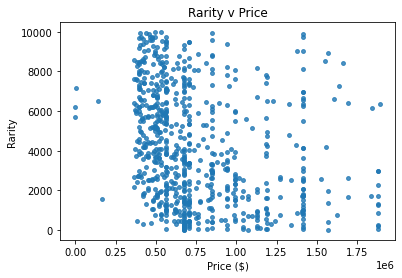

      rarity         Price  Symbol  Labels
ID                                        
1859    6511  1.401500e+05  dollar       4
3368    7187  2.803000e+03  dollar       4
5448    1579  1.681800e+05  dollar       4
5465    6204  0.000000e+00  dollar       4
8520    5683  2.803000e-09  dollar       4


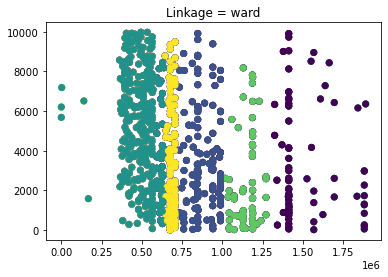

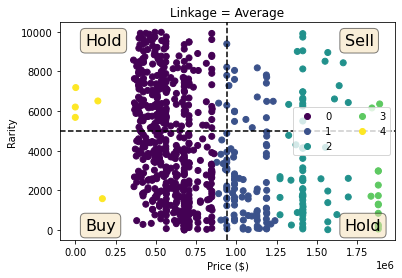

In [109]:
NFT_analysis('PricesBoredApeYachtClub.csv', 'Bored.csv')

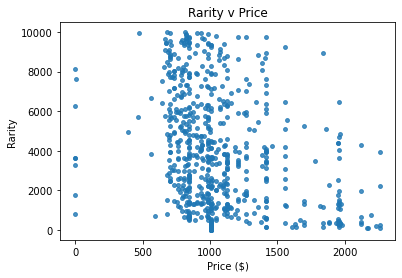

      rarity      Price  Symbol  Labels
ID                                     
13      9954   904.3200  dollar       4
22      9839   822.3660  dollar       4
343     8746   847.5174  dollar       4
370     9743   844.9740  dollar       4
466     9458   810.4968  dollar       4
...      ...        ...     ...     ...
9450    9265  1554.3000  dollar       4
9456    9398  1102.1400  dollar       4
9884    9734  1206.4194  dollar       4
9968    9663   819.5400  dollar       4
9991    8728   706.2174  dollar       4

[66 rows x 4 columns]


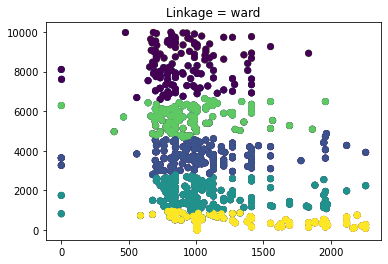

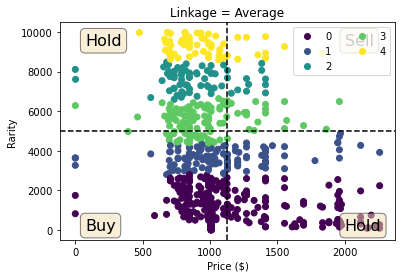

In [107]:
dff = NFT_analysis('DoodlesPrices.csv', 'Doodles.csv')

In [45]:
dff

,rarity,Price,Symbol
ID,,,
9,4154,100859.9400,dollar
10,1044,113040.0000,dollar
13,9954,90432.0000,dollar
22,9839,82236.6000,dollar
30,3264,0.8409,dollar
...,...,...,...
9949,7751,72063.0000,dollar
9968,9663,81954.0000,dollar
9975,7708,84780.0000,dollar


In [47]:
outlier_analysis(dff)

,rarity,Price,Symbol
ID,,,
9,4154,100859.940,dollar
10,1044,113040.000,dollar
13,9954,90432.000,dollar
22,9839,82236.600,dollar
30,3264,100867.005,dollar
...,...,...,...
9949,7751,72063.000,dollar
9968,9663,81954.000,dollar
9975,7708,84780.000,dollar


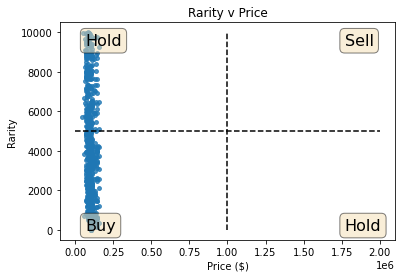

In [48]:
graphs(dff)